# Application to Data

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import sys 
import hickle as hck
import dill

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

sys.path.insert(0, '../energy_calibration/rebin/')
sys.path.insert(0, '../dpx_func/dpx_func_python/dpx_func_python')
import rebin as rb
import plotTemperatureToT as pttt
import ToTtoEnergy as tte
import DPXhistSupport as dhs
reload(dhs)

<module 'DPXhistSupport' from 'DPXhistSupport.py'>

## Specify Files

In [142]:
PLOT_DIR = 'publish/'

# Energy region
REGION = 4

# Main directory
# dataDir = './doseDennisAm/doseDennis_10_80keV_allSlots/'
# dataDir = './doseSource/doseMeasurement_Dennis_Am_region/'
dataDir = './pileUp/80kV_25mA_noPhantom/80kV_25mA_noPhantom_range%d/'
# dataDir = './doseSource/doseMeasurement_Dennis_Ba_2min/'
# Dose Measurement
doseFile = 'doseMeasurement.hck'
# Temperature Measurement (optional)
tempFile = None
# Temperature Calibration
tempCalibFile = None
# Energy conversion factors
paramsDictFile = 'doseDennisAm/paramsDict_Dennis2.hck'
# Used bin edges (in energy)
binEdgesFile = 'binEdgesUniform_Dennis.hck'

# Specify slot
SLOT = [1, 2, 3]
# Specify number of bins after rebinning
REBINS = 500
# Bin width
bin_width = 0.2 # keV

## Load Files

### Single File

In [103]:
doseDict = hck.load(dataDir + doseFile)
doseDict = {slot: np.asarray(doseDict[slot])[:,:,:,1:] for slot in doseDict.keys()}

if tempFile is not None:
    tempDict = hck.load(dataDir + tempFile)
    tempCalibDict = hck.load(tempCalibFile)
else:
    tempDict = None
    tempCalibDic = None
binEdgesRandomDict = hck.load(dataDir + binEdgesFile)
paramsDict = hck.load(paramsDictFile)

### Region Load
#### One File

In [106]:
doseDict_ = hck.load(dataDir + doseFile)
print doseDict_['Slot1'].keys()

doseDict = {}
for slot in doseDict_.keys():
    sumList = []
    for region in reversed(range(4)):
        d = doseDict_[slot]['Region%d' % region]
        if not d:
            continue
        data = np.sum(d, axis=0)[:,:,1:] / float(len(d))
        print np.sum(data[:,:,-1]), data.shape
        # plt.imshow(data.reshape((256, -1)).T, aspect='auto')
        # plt.show()
        sumList.append( data )
    temp = np.dstack(sumList)
    doseDict[slot] = temp.reshape([1] + list(temp.shape))

IOError: Unable to open file (unable to open file: name = './pileUp/80kV_25mA_noPhantom/80kV_25mA_noPhantom_range%d/doseMeasurement.hck', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [4]:
doseDict['Slot1'].shape

(5826, 16, 16, 15)

### Combine Regions
#### Multiple Files

In [143]:
dictList = []
for region in range(4):
    try:
        dictList.append( hck.load(dataDir % region + doseFile) )
    except:
        pass

if tempFile is not None:
    tempDict = hck.load(dataDir + tempFile)
    tempCalibDict = hck.load(tempCalibFile)
else:
    tempDict = None
    tempCalibDic = None
    
binEdgesRandomDict = hck.load(dataDir % region + binEdgesFile)

In [144]:
doseDict = {}
for slot in dictList[0].keys():
    sumList = []
    for region in reversed(range(len(dictList))):
        data = np.sum(dictList[region][slot], axis=0)[:,:,1:] / float(len(dictList[region][slot]))
        print np.sum(data[:,:,-1]), data.shape
        # plt.imshow(data.reshape((256, -1)).T, aspect='auto')
        # plt.show()
        sumList.append( data )
        
    temp = np.dstack(sumList)
    doseDict[slot] = temp.reshape([1] + list(temp.shape))
    print

3889.25 (16, 16, 15)
16971.6 (16, 16, 15)
161420.2 (16, 16, 15)
2170292.0 (16, 16, 15)

0.0 (16, 16, 15)
0.25 (16, 16, 15)
300.75 (16, 16, 15)
54426.00000000001 (16, 16, 15)

3161.75 (16, 16, 15)
16576.25 (16, 16, 15)
164103.25 (16, 16, 15)
1873791.0 (16, 16, 15)



In [145]:
newEdgesDict = {}
for slot in binEdgesRandomDict.keys():
    print np.asarray(binEdgesRandomDict[slot]).shape
    newEdges = np.hstack(np.asarray(binEdgesRandomDict[slot])[:,:,:-2])
    print newEdges.shape
    newEdgesDict[slot] = newEdges

(4, 256, 17)
(256, 60)
(4, 256, 17)
(256, 60)
(4, 256, 17)
(256, 60)


In [146]:
binEdgesCorrDict = newEdgesDict

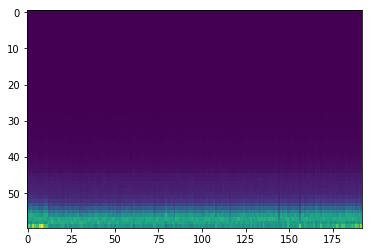

In [147]:
plt.imshow(np.reshape(np.sum(doseDict['Slot%d' % 1], axis=0), (256, -1))[largePixels].T, aspect='auto')

## Temperature Correction (optional)

In [67]:
if tempDict is not None and tempCalibDict is not None:
    binEdgesCorrDict = dhs.correctTemperature(binEdgesDict, tempDict, tempCalibDict, slot=SLOT)
else:
    binEdgesCorrDict = binEdgesRandomDict

In [89]:
doseDictOrig = doseDict

In [90]:
doseDict = {key: doseDictOrig[key][23:24] for key in doseDictOrig.keys()}

## Data Distribution

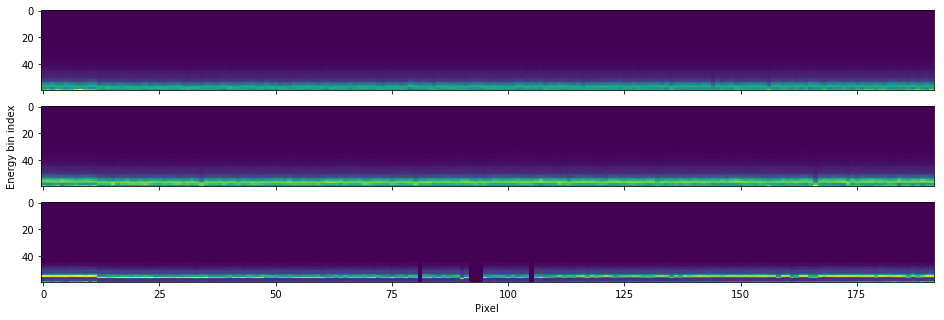

In [148]:
fig, ax = plt.subplots(len(SLOT), 1, figsize=(16, 5), sharex=True)
largePixels = np.asarray([pixel for pixel in np.arange(256) if pixel % 16 not in [0, 1, 14, 15]])
for idx, slot in enumerate( SLOT ):
    ax[idx].imshow( np.reshape(np.sum(doseDict['Slot%d' % slot], axis=0), (256, -1))[largePixels].T, aspect='auto' )
ax[-1].set_xlabel('Pixel')
ax[1].set_ylabel('Energy bin index')
fig.savefig(PLOT_DIR + 'data_distribution.svg')

## Rebinning

In [134]:
SAVE_DATA = False
SAVE_DATA_FN = 'data_export/' + dataDir.split('/')[-2] + '.dill'
titles = ['vac', 'al', 'sn']

In [135]:
print SAVE_DATA_FN

data_export/80kV_25mA_strangeSetup_range%d.dill


5.3576388888888875 280.6666666666667
(256, 60)
(690,) (690,)
5.3576388888888875 280.6666666666667
(256, 60)
(690,) (690,)
5.3576388888888875 280.6666666666667
(256, 60)
(690,) (690,)


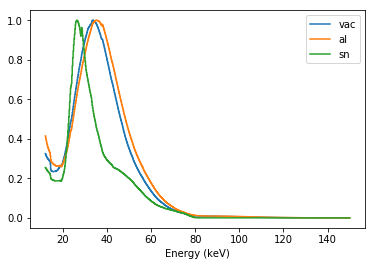

In [139]:
save_data_dict = {}

energy_max = 150
for slot in SLOT:
    # Get minimum and maximum energy values
    flatEdges = np.asarray(binEdgesCorrDict['Slot%d' % slot]).T[:-1].flatten()
    minE, maxE = min(flatEdges), max(flatEdges)
    print minE, maxE

    # Sum over frames and flatten
    dose = np.flip( np.reshape( np.sum(np.asarray(doseDict['Slot%d' % slot]), axis=0), (256, -1) ), axis=1)
    # plt.imshow(dose.T, aspect='auto')
    # plt.show()
    print dose.shape
    
    # Rebin data
    # print binEdgesCorrDict['Slot%d' % slot].shape
    binsNew, histNew = dhs.rebinEnergyData(binEdgesCorrDict['Slot%d' % slot], dose)
    xNew = np.arange(minE, maxE + bin_width, bin_width) # np.linspace(minE, maxE, REBINS)
    yNew = np.nan_to_num(rb.rebin(binsNew, histNew, xNew, interp_kind='piecewise_constant'))

    if slot == 1:
        slot1max = np.max(yNew)
        
    x = xNew[:-1][np.logical_and(xNew[:-1] > 12, xNew[:-1] < energy_max)]
    y = yNew[np.logical_and(xNew[:-1] > 12, xNew[:-1] < energy_max)]
    # x, y = xNew[:-1], yNew
    print x.shape, y.shape
    y /= slot1max

    save_data_dict[titles[slot - 1]] = y
    # Plot
    plt.step(x, y / np.max(y), where='post', label=titles[slot-1])
        
save_data_dict['bins'] = x
        
if SAVE_DATA:
    dill.dump(save_data_dict, open(SAVE_DATA_FN, 'wb'))

if len(SLOT) > 1:
    plt.legend()

# plt.yscale('log')
# plt.xlim(minE, maxE)
_ = plt.xlabel('Energy (keV)')
plt.savefig(PLOT_DIR + 'spectrum_meas.svg')

## Window Estimation

((317.03645153805746, 26.163888888888888, 5), array([319.74265491,  26.06944715,   5.86808135]))
((317.26682841594516, 46.16388888888889, 5), array([320.56759155,  46.08253606,   5.86735702]))
((316.02338683443065, 66.16388888888889, 5), array([320.7306842 ,  66.06697756,   5.86636257]))
((318.1370610143893, 86.1638888888889, 5), array([320.54064628,  86.07845355,   5.86871802]))
((114.51876252217369, 106.1638888888889, 5), array([114.51876252, 106.16388889,   5.        ]))
5.694103792348462


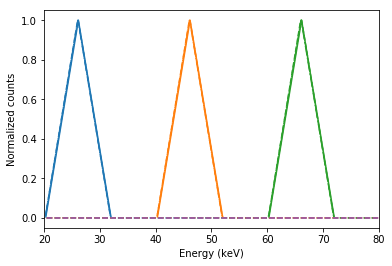

In [73]:
slot = 1
x = np.linspace(minE, maxE, REBINS)
isLarge = np.asarray([pixel for pixel in np.arange(256) if pixel % 16 not in [0, 1, 14, 15]])
windowTau = dhs.estimateWindow(x, np.asarray(binEdgesCorrDict['Slot%d' % slot])[isLarge], dhs.triangleWindow, meanRange=np.arange(minE + 20, minE + 120, 20), plot=True)
plt.savefig(PLOT_DIR + 'data_window_estimation_tri.svg')

In [44]:
print(len(xWindow))
print(np.argmin(abs(xWindow - .5*maxE)))

439
205


## Deconvolution

5.694103792348462
2440
(440, 440)
5.694103792348462
2440
(440, 440)
5.694103792348462
2440
(440, 440)


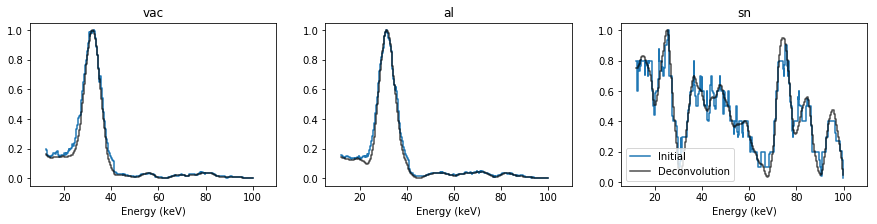

In [74]:
lambd = 10

fig, ax = plt.subplots(1, 3, figsize=(15, 3))
for idx, title in enumerate(['vac', 'al', 'sn']):
    xNew, yNew = save_data_dict['bins'], save_data_dict[title]
    
    # Get Window
    padFront, padBack = 1000, 1000
    bins = xNew
    xWindow = np.linspace(minE, maxE, len(bins[:-1])) 
    yWindow = np.asarray(dhs.triangleWindow(xWindow, 1, 0.5 * maxE, windowTau))
    yWindow = 1 * yWindow / float(max(yWindow))

    print windowTau
    # plt.step(xWindow, yWindow, where='post')
    # plt.show()
    
    # Initial data
    hist = np.pad(yNew, (padFront, padBack), 'constant', constant_values=(yNew[0], 0))

    # Deconvolved data
    deconv = dhs.wiener_deconvolution(hist, yWindow, lambd=lambd)
    deconv[deconv < 0] = 0    # Reject negative values
    # deconv = np.asarray(list(deconv[-xWindowMax//2:]) + list(deconv[:-xWindowMax//2]))
    print(len(deconv))
    # print(xWindowMax)
    print(len(xNew), len(bins))

    # Plot
    ax[idx].step(xNew, yNew / np.max(yNew), where='post', label='Initial')
    ax[idx].step(bins, deconv[padFront-220+int(windowTau)+10:-padBack-220+int(windowTau)+10] / max(deconv), color='k', alpha=.7, label='Deconvolution', where='post')

    ax[idx].set_xlim(0.9 * minE, 1.1 * maxE)
    ax[idx].set_xlabel('Energy (keV)')
    ax[idx].set_title(title)
plt.legend()
plt.savefig(PLOT_DIR + 'spectrum_deconv.svg')
plt.show()

## Batch-Processing